# <b> Titanic - Machine Learning from Disaster

![](Titanic.png)


source: https://www.kaggle.com/c/titanic/data

In [396]:
# import Lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [397]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [398]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [399]:
test_df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [400]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [401]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**PassengerId**

The first column is the passenger ID. The ID for a passenger is just number to identify this passenger in this dataset. So this column is not really a part of the information we should care about. We can drop this column or make it the index for this dataset. Let's make it the index for the dataset just to demonstrate the use of `df.set_index` method

In [402]:
train_df.set_index(train_df.PassengerId, inplace=True)
train_df.drop('PassengerId', axis=1, inplace=True)

In [403]:
test_df.set_index(test_df.PassengerId, inplace=True)
test_df.drop('PassengerId', axis=1, inplace=True)

In [404]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [405]:
test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 1. Feature Classification: Categorical vs Numerical
* This help us select the appropriate plots for visualization

Which feature are categorical?

* Categorical feature: `nominal`, `ordinal`, `ratio`, `interval`.
* To classify the samples into sets of similar samples.

Which feature are numerical?
* Numerical feature: `discrete`, `continuous`, `timeseries`.
* These value change from sample to sample.

In [406]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [407]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [408]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* Categorical: `Survived`, `Sex`, `Embarked`, `Pclass` (ordinal), `SibSp`, `Parch`.
* Numerical: (Continuous)`Age`, `Fare`(discrete).
* Mix type of data: `Ticket`, `Cabin`.
* Contain Error/Typo: `Name`.
* Blank or Null: `Cabin` > `Age` > `Embarked`.
* Varous data type: `string`, `int`, `float`.

In [409]:
# Change data type for "Survived", "Sex", "Embarked", "Pclass", "SibSp", "Parch" to "category"
features = ["Survived", "Sex", "Embarked", "Pclass", "SibSp", "Parch"]
def convert_cat(df, features):
    for feature in features:
        if feature in df.columns:
            df[feature] = df[feature].astype("category")
        else:
            pass
convert_cat(train_df, features)
convert_cat(test_df, features)

In [410]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    category
 1   Pclass    891 non-null    category
 2   Name      891 non-null    object  
 3   Sex       891 non-null    category
 4   Age       714 non-null    float64 
 5   SibSp     891 non-null    category
 6   Parch     891 non-null    category
 7   Ticket    891 non-null    object  
 8   Fare      891 non-null    float64 
 9   Cabin     204 non-null    object  
 10  Embarked  889 non-null    category
dtypes: category(6), float64(2), object(3)
memory usage: 48.2+ KB


In [411]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    418 non-null    category
 1   Name      418 non-null    object  
 2   Sex       418 non-null    category
 3   Age       332 non-null    float64 
 4   SibSp     418 non-null    category
 5   Parch     418 non-null    category
 6   Ticket    418 non-null    object  
 7   Fare      417 non-null    float64 
 8   Cabin     91 non-null     object  
 9   Embarked  418 non-null    category
dtypes: category(5), float64(2), object(3)
memory usage: 22.7+ KB


### 1.1. Distribution of numerical feature values across the samples
(Phân bổ numerical feature values)

In [412]:
train_df.describe()

,Age,Fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200


**Observation:** <br>
* There are `714` values ​​in the dataset, the Age column has a missing value.
* The average age of passengers boarding the train is nearly `30 years old`. The smallest is `0.42` (newborn), the largest is `80` years old.
* The average fare is `32.2$`, the smallest is `0$`, the largest is `512.3$`

### 1.2. Distribution of categorical feature values across the samples

In [413]:
train_df.describe(include=["category"])

,Survived,Pclass,Sex,SibSp,Parch,Embarked
count,891,891,891,891,891,889
unique,2,3,2,7,7,3
top,0,3,male,0,0,S
freq,549,491,577,608,678,644


**Observation:** <br>
* **Survived:** There are 2 types 0 (dead), 1 (alive) and there are `549` dead people out of `891` people.
* **Pclass:** There are 3 types of tickets, type 3 tickets are the most popular with `491` tickets out of `891` tickets.
* **Sex:** Men are more popular than women with `577` people.
* **SibSp:** There are `608` people who do not bring friends, wives, etc.
* **Parch:** There are `678` people who do not bring parents, children, etc.
* **Embarked:** There are `644` people departing from port S (Southampton).

## 2. Exploratory Data Analysis (EDA)
### 2.1. Correlating categorical feature
* Categorical: `Sex`, `Embarked`, `Pclass` (ordinal), `SibSp`, `Parch`.

**Target Variable**: `Survived`

In [414]:
# Có bao nhiều người chết và sống sót.
train_df["Survived"].value_counts().to_frame()

,count
Survived,
0,549
1,342


In [415]:
# % người sống sót và chết
train_df["Survived"].value_counts(normalize=True).to_frame()

,proportion
Survived,
0,0.616162
1,0.383838


🟢 Only `38%` survived the disaster. So the training data is suffers from data imbalance but it is not severe, which is why I will not consider techniques like sampling to tackle the imbalance.
#### 2.1.1. Sex

In [416]:
# Phân bố nam nữ trên tàu.
train_df["Sex"].value_counts().to_frame()

,count
Sex,
male,577
female,314


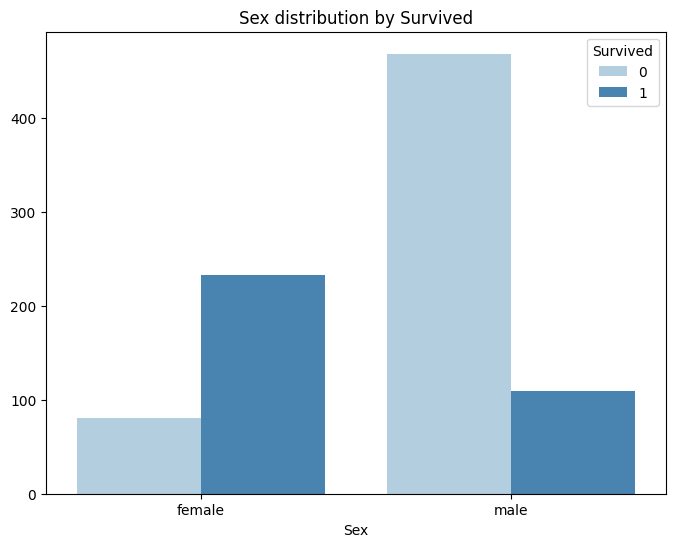

In [417]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train_df, x = "Sex", palette="Blues", hue="Survived");
plt.title("Sex distribution by Survived")
plt.xlabel('Sex')
plt.ylabel('')
plt.show()

In [418]:
crosstab = pd.crosstab(train_df["Survived"], train_df["Sex"])
chi2, p, dof, expected = chi2_contingency(crosstab)

print(f"\nChi-Square Test for Sex:")
print(f"Chi2 statistic: {chi2:.3f}")
print(f"Degrees of freedoom: {dof}")
print(f"p - value: {p}")
if p <= 0.05:
    print("🔴 Survived depends on Sex")
else:
    print("⚪ Survived does not depend on Sex")


Chi-Square Test for Sex:
Chi2 statistic: 260.717
Degrees of freedoom: 1
p - value: 1.1973570627755645e-58
🔴 Survived depends on Sex


🟢 For females, the number of survivors is twice as high as that of males. <br>
=> This shows that in the event of an accident, women are given priority over men, so the survival rate of women is higher.

#### 2.1.2. Remaining categorical feature columns

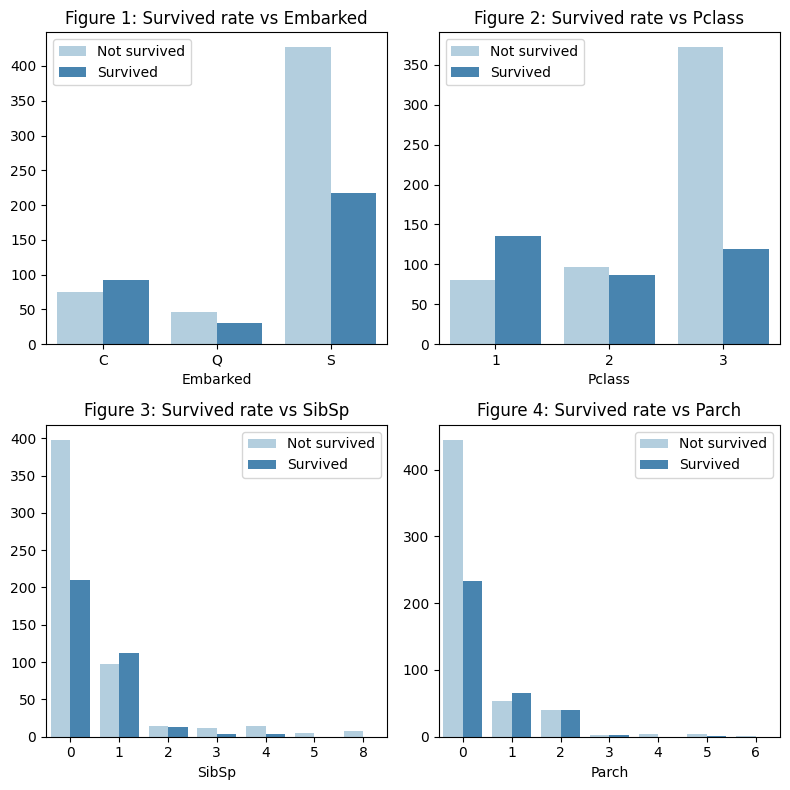

In [419]:
cols = ["Embarked", "Pclass", "SibSp", "Parch"]
n_rows = 2
n_cols = 2

fig, ax = plt.subplots(n_rows, n_cols, figsize = (n_cols * 4, n_rows * 4))

for r in range(0, n_rows):
    for c in range(0, n_cols):
        i = r * n_cols + c # index to loop through list "cols"
        if i < len(cols):
            ax_i = ax[r, c]
            sns.countplot(data=train_df, x = cols[i], palette="Blues", hue="Survived", ax=ax_i);
            ax_i.set_title(f"Figure {i + 1}: Survived rate vs {cols[i]}")
            if r == 0:
                ax_i.legend(title = '', loc= "upper left", labels = ["Not survived", "Survived"])
            else:
                ax_i.legend(title = '', loc= "upper right", labels = ["Not survived", "Survived"])
            ax_i.set_ylabel("")
        else:
            pass

plt.tight_layout()
plt.show()

In [420]:
def calculate_ChiSquare(train_df, feature):
    for i in feature:
        crosstab = pd.crosstab(train_df["Survived"], train_df[i])
        chi2, p, dof, expected = chi2_contingency(crosstab)
        print(f"\nChi-Square Test for {i}:")
        print(f"Chi2 statistic: {chi2:.3f}")
        print(f"Degrees of freedoom: {dof}")
        print(f"p - value: {p}")
        if p <= 0.05:
            print(f"🔴 Survived depends on {i}")
        else:
            print(f"⚪ Survived does not depend {i}")
        print("-------------------------------------------------------------------")
calculate_ChiSquare(train_df, cols)


Chi-Square Test for Embarked:
Chi2 statistic: 26.489
Degrees of freedoom: 2
p - value: 1.769922284120912e-06
🔴 Survived depends on Embarked
-------------------------------------------------------------------

Chi-Square Test for Pclass:
Chi2 statistic: 102.889
Degrees of freedoom: 2
p - value: 4.549251711298793e-23
🔴 Survived depends on Pclass
-------------------------------------------------------------------

Chi-Square Test for SibSp:
Chi2 statistic: 37.272
Degrees of freedoom: 6
p - value: 1.5585810465902118e-06
🔴 Survived depends on SibSp
-------------------------------------------------------------------

Chi-Square Test for Parch:
Chi2 statistic: 27.926
Degrees of freedoom: 6
p - value: 9.703526421039996e-05
🔴 Survived depends on Parch
-------------------------------------------------------------------


**Observation:** <br>
* Survival rate: <br>
🟢 Fig 1: Most people embarked on Southampton, and also had the highest people not survived. <br>
🟢 Fig 2: 1st class higher survival rate. <br>
🟢 Fig 3: People going with 0 `SibSp` are mostly not survived, the number of passenger with 1 - 2 family members has a better chance of survival. <br>
🟢 Fig 4: People going with 0 `Parch` are mostly not survived.

### 2.2 EDA for numerical feature
* Numerical features: `Age`, `Fare`

#### 2.2.1. Age

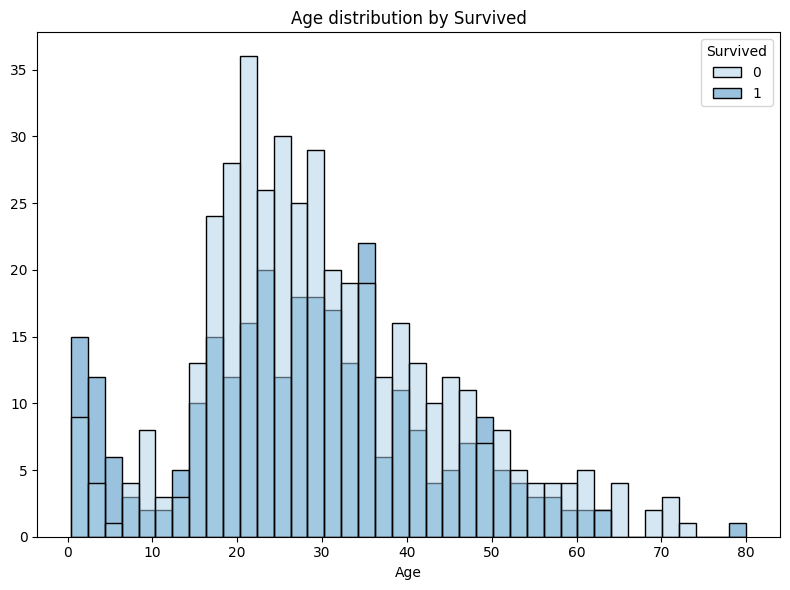

In [421]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x="Age", bins = 40, hue = "Survived", palette="Blues");
plt.title("Age distribution by Survived")
plt.xlabel('Age')
plt.ylabel('')
plt.tight_layout()
plt.show()

**Observation:** <br>
🟢 Majority passengers were from 18 - 50 ages. <br>
🟢 Children had more chance to survive than other ages.

In [422]:
train_df["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

#### 2.2.2. Fare

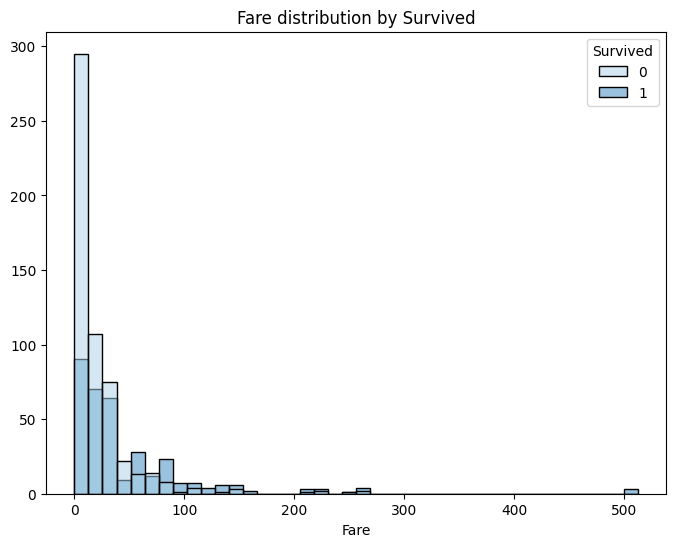

In [423]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x="Fare", bins = 40, hue = "Survived", palette="Blues");
plt.title("Fare distribution by Survived")
plt.xlabel('Fare')
plt.ylabel('')
plt.show()

**Problem** <br>
Based on the visual chart, it will be difficult to see, we can divide it into 4 ranges. <br>
0 - 25%, 25% - 50%, 50% - 75%, 75% - 100% <br>
![](box.png)

In [424]:
# To name for 0 - 25%, 25% - 50%, 50% - 75%, 75% - 100%
fare_category = ["Economic", "Standard", "Expensive", "Luxury"]
quartile_data = pd.qcut(train_df["Fare"], 4, labels=fare_category)

quartile_data

PassengerId
1       Economic
2         Luxury
3       Standard
4         Luxury
5       Standard
         ...    
887     Standard
888    Expensive
889    Expensive
890    Expensive
891     Economic
Name: Fare, Length: 891, dtype: category
Categories (4, object): ['Economic' < 'Standard' < 'Expensive' < 'Luxury']

In [425]:
train_df["Fare"]

PassengerId
1       7.2500
2      71.2833
3       7.9250
4      53.1000
5       8.0500
        ...   
887    13.0000
888    30.0000
889    23.4500
890    30.0000
891     7.7500
Name: Fare, Length: 891, dtype: float64

<Axes: xlabel='Fare', ylabel='count'>

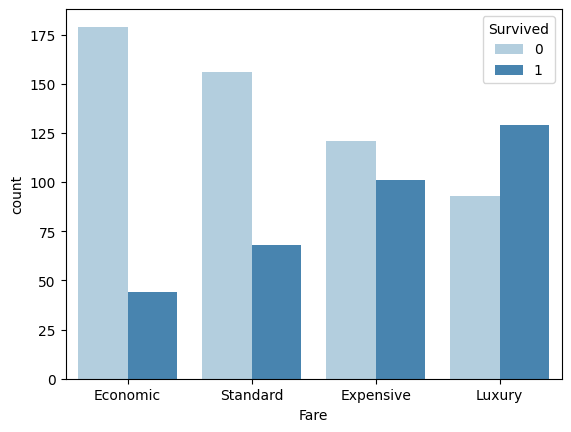

In [426]:
sns.countplot(x=quartile_data, hue=train_df["Survived"], palette="Blues")

**Observation:** <br>
* Distribution of fare <br>
🟢 Fare does not allow a normal distribution and has a huge spike at the price range `[0 - 100$]`. <br>
🟢 The distribution is skewed to the left with 75% of the fare paid under `31$` and a max paid fare `$512`. <br>
* Quartile plot <br>
🟢 Passenger with Luxury and Expensive Fare will have more chance to survive.

## 3. Feature Engineering and data wrangling
### 3.1 Feature Engineering

#### 3.1.1 Name

In [427]:
train_df["Name"]

PassengerId
1                                Braund, Mr. Owen Harris
2      Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                 Heikkinen, Miss. Laina
4           Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                               Allen, Mr. William Henry
                             ...                        
887                                Montvila, Rev. Juozas
888                         Graham, Miss. Margaret Edith
889             Johnston, Miss. Catherine Helen "Carrie"
890                                Behr, Mr. Karl Howell
891                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [428]:
import re

def extract_title(name):
    p = re.compile(r",\s*([\w\s]+)\.")
    return p.search(name).groups(1)[0].strip()

train_df["Title"] = train_df["Name"].apply(lambda name: extract_title(name))

In [429]:
train_df["Title"].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

In [430]:
test_df["Title"] = test_df["Name"].apply(lambda name: extract_title(name))
test_df["Title"].value_counts()

Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64

In [431]:
def group_title(title):
    if title in ["Mr", "Mrs", "Miss", "Master"]:
        return title
    elif title == "Ms":
        return "Miss"
    else:
        return "Others"

train_df["Title"] = train_df["Title"].apply(lambda title: group_title(title))
test_df["Title"] = test_df["Title"].apply(lambda title: group_title(title))

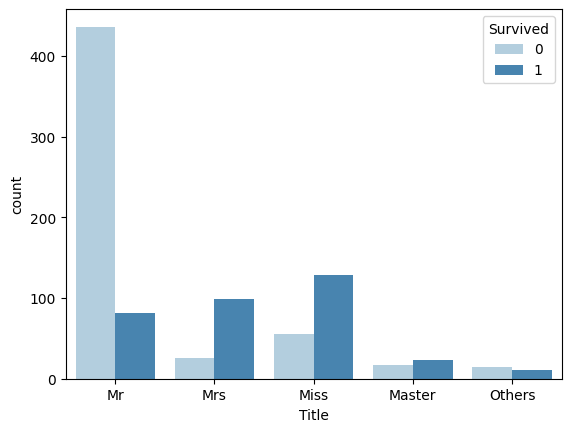

In [432]:
sns.countplot(data=train_df, x="Title", hue = "Survived", palette="Blues");

#### 3.1.2. Family
* `SibSp`, `Parch`

In [433]:
# Gộp 2 column SibSp và Parch lại với nhau.
train_df["Family_Size"] = train_df["SibSp"].astype("int8") + train_df["Parch"].astype("int8") + 1

In [434]:
test_df["Family_Size"] = test_df["SibSp"].astype("int8") + test_df["Parch"].astype("int8") + 1

In [435]:
train_df["Family_Cat"] = pd.cut(train_df["Family_Size"], bins = [0, 1, 4, 6, 20], labels= ["Solo", "Small", "Medium", "Large"])
# (0, 1], (1, 4], (4, 6], (6, 20]

In [436]:
test_df["Family_Cat"] = pd.cut(test_df["Family_Size"], bins = [0, 1, 4, 6, 20], labels= ["Solo", "Small", "Medium", "Large"])
# (0, 1], (1, 4], (4, 6], (6, 20]

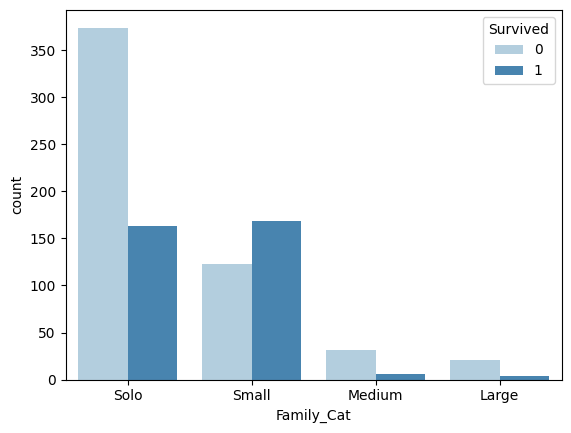

In [437]:
sns.countplot(data=train_df, x = "Family_Cat", hue="Survived", palette="Blues");

In [438]:
cols = ["Family_Cat", "Title"]
calculate_ChiSquare(train_df, cols)


Chi-Square Test for Family_Cat:
Chi2 statistic: 74.538
Degrees of freedoom: 3
p - value: 4.552176986136296e-16
🔴 Survived depends on Family_Cat
-------------------------------------------------------------------

Chi-Square Test for Title:
Chi2 statistic: 284.283
Degrees of freedoom: 4
p - value: 2.65806363131506e-60
🔴 Survived depends on Title
-------------------------------------------------------------------


**Observation:** <br>
🟢 People who go solo have a very low chance of survival. <br>
🟢 People who go with a small number of companions have a high chance of survival. <br>
🟢 People with a large number of companions have a very low chance of survival. <br>

### 3.2. Data wrangling

In [439]:
num_feature = ["Age", "Fare"]
cat_feature = ["Sex", "Pclass", "Embarked", "Title", "Family_Cat"]
feature_col = num_feature + cat_feature
print(feature_col)

['Age', 'Fare', 'Sex', 'Pclass', 'Embarked', 'Title', 'Family_Cat']


In [440]:
def display_missing(df, feature_col):
    n_rows = df.shape[0]
    for col in feature_col:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            print(f"Col {col} has {missing_count}({missing_count * 100 / n_rows:.2f}%) missing value.")
display_missing(train_df, feature_col)
display_missing(test_df, feature_col)


Col Age has 177(19.87%) missing value.
Col Embarked has 2(0.22%) missing value.
Col Age has 86(20.57%) missing value.
Col Fare has 1(0.24%) missing value.


#### 3.2.1. Filling missing value

##### Age
* Filling missing values with `median` of whole dataset

In [441]:
age_by_sex_pclass = train_df.groupby(["Sex", "Pclass"], observed=True).median(numeric_only = True)["Age"]
age_by_sex_pclass

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64

In [442]:
# Filling the missing value in Age with the medians of Sex and Pclass groups.
train_df["Age"] = train_df.groupby(["Sex", "Pclass"], observed=True)["Age"].transform(lambda x: x.fillna(x.median(numeric_only=True)))

In [443]:
test_df["Age"] = test_df.groupby(["Sex", "Pclass"], observed=True)["Age"].transform(lambda x: x.fillna(x.median(numeric_only=True)))

In [444]:
display_missing(train_df, feature_col)
display_missing(test_df, feature_col)

Col Embarked has 2(0.22%) missing value.
Col Fare has 1(0.24%) missing value.


In [445]:
X = train_df[feature_col]
y = train_df["Survived"]

In [446]:
X_test = test_df[feature_col]

* Categorical: `Survived`, `Sex`, `Embarked`, `Pclass` (ordinal), `SibSp`, `Parch`.
* Numerical: (Continuous)`Age`, `Fare`(discrete).
* Mix type of data: `Ticket`, `Cabin`.
* Contain Error/Typo: `Name`.
* Blank or Null: `Cabin` > `Age` > `Embarked`.
* Varous data type: `string`, `int`, `float`.

In [447]:
# Process pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# num_feature = ["Age", "Fare"]
# cat_feature = ["Sex", "Pclass", "Embarked", "Title", "Family_Cat"]

num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy = "median")), # Will fill missing value for Embarked and Fare and get median value.
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy = "most_frequent")),  # Will fill missing value for Embarked and Fare and get median value.
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [448]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_feature),
        ("cat", cat_transformer, cat_feature),
    ]
)

In [449]:
preprocessor.fit(X)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'Pclass', 'Embarked', 'Title',
                                  'Family_Cat'])])

In [450]:
X = preprocessor.transform(X) # X -> X_train, X_val

In [451]:
X_test = preprocessor.transform(X_test)

## 4. Model Training

![](Model_Training.png)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [453]:
X_train.shape, X_val.shape

((712, 19), (179, 19))

In [454]:
X_test.shape

(418, 19)

In [474]:
# binary classification
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix

In [456]:
log_reg = LogisticRegression(solver="liblinear", max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [457]:
log_reg.score(X_val, y_val)

0.8603351955307262

In [458]:
y_pred = log_reg.predict(X_val)

In [460]:
precision_score(y_val, y_pred), recall_score(y_val, y_pred)

(0.8153846153846154, 0.803030303030303)

In [461]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       113
           1       0.82      0.80      0.81        66

    accuracy                           0.86       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.86      0.86      0.86       179



* y = ax1 + bx2 + bias -> y = ax1^2 + bx2^2 +...+ bias

In [471]:
poly = PolynomialFeatures(degree=2)
poly_feature_X_train = poly.fit_transform(X_train)
poly_feature_X_val = poly.transform(X_val)

In [472]:
poly_log_reg = LogisticRegression(solver="liblinear", max_iter=1000)
poly_log_reg.fit(poly_feature_X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [473]:
poly_log_reg.score(poly_feature_X_val, y_val)

0.8547486033519553

In [ ]:
# Decision tree
decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=5, random_state=2025)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=2025)

In [478]:
decision_tree.score(X_val, y_val)

0.8715083798882681

## 5. Cross - validation
![](Cross_Validation.png)

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
log_reg_cv = LogisticRegression(solver="liblinear", max_iter=1000)
dt_cv = DecisionTreeClassifier(criterion="entropy", max_depth=5, random_state=2025)

lr_scores = cross_val_score(log_reg_cv, X, y, scoring="accuracy", cv=5)